# Mobile Robotics Project Report

## Table of Content:
* [1. Introduction](#Introduction)
* [2. General program flow](#General_program_flow)
* [3. Computer Vision](#Computer_vision )
* [4. Filtering](#Filtering)
* [5. General Motion](#General_motion)
* [6. Local avoidance](#Local_avoidance)
* [7. Kidnapping](#Kidnapping)
* [8. Conclusion](#Conclusion)
  


## Project: Autonomous Navigation System for a Mobile Robot

### Participants:
- **Alexis Limozin  (330717)**
- **Parth Aggarwal  (376263)**
- **Serge Elasmar   (326623)**
- **Quentin Angéloz (325935)**

---

# 1. Introduction <a class="anchor" id="Introduction"></a>
The aim of our project is to manage the thymio's path to a target in an environment containing obstacles.
Our project uses a camera to create a map of the environment, taking obstacles into account. The thymio plans its path based on this map, and travels to where the obstacle is. If the environment changes and the robot detects an unexpected obstacle, the camera generates a new map that takes the new obstacle into account, and the thymio corrects its route.
## Assumptions and environment description
- The environment is a plane.
- The ground is only one color, not green, not black and not red.
- Obstacles color is black
- The goal color is green
- Operate the camera, obstacles and robot in a controlled environment
- The Thymio is identified by two unique pieces of red tape

## Environment Visual

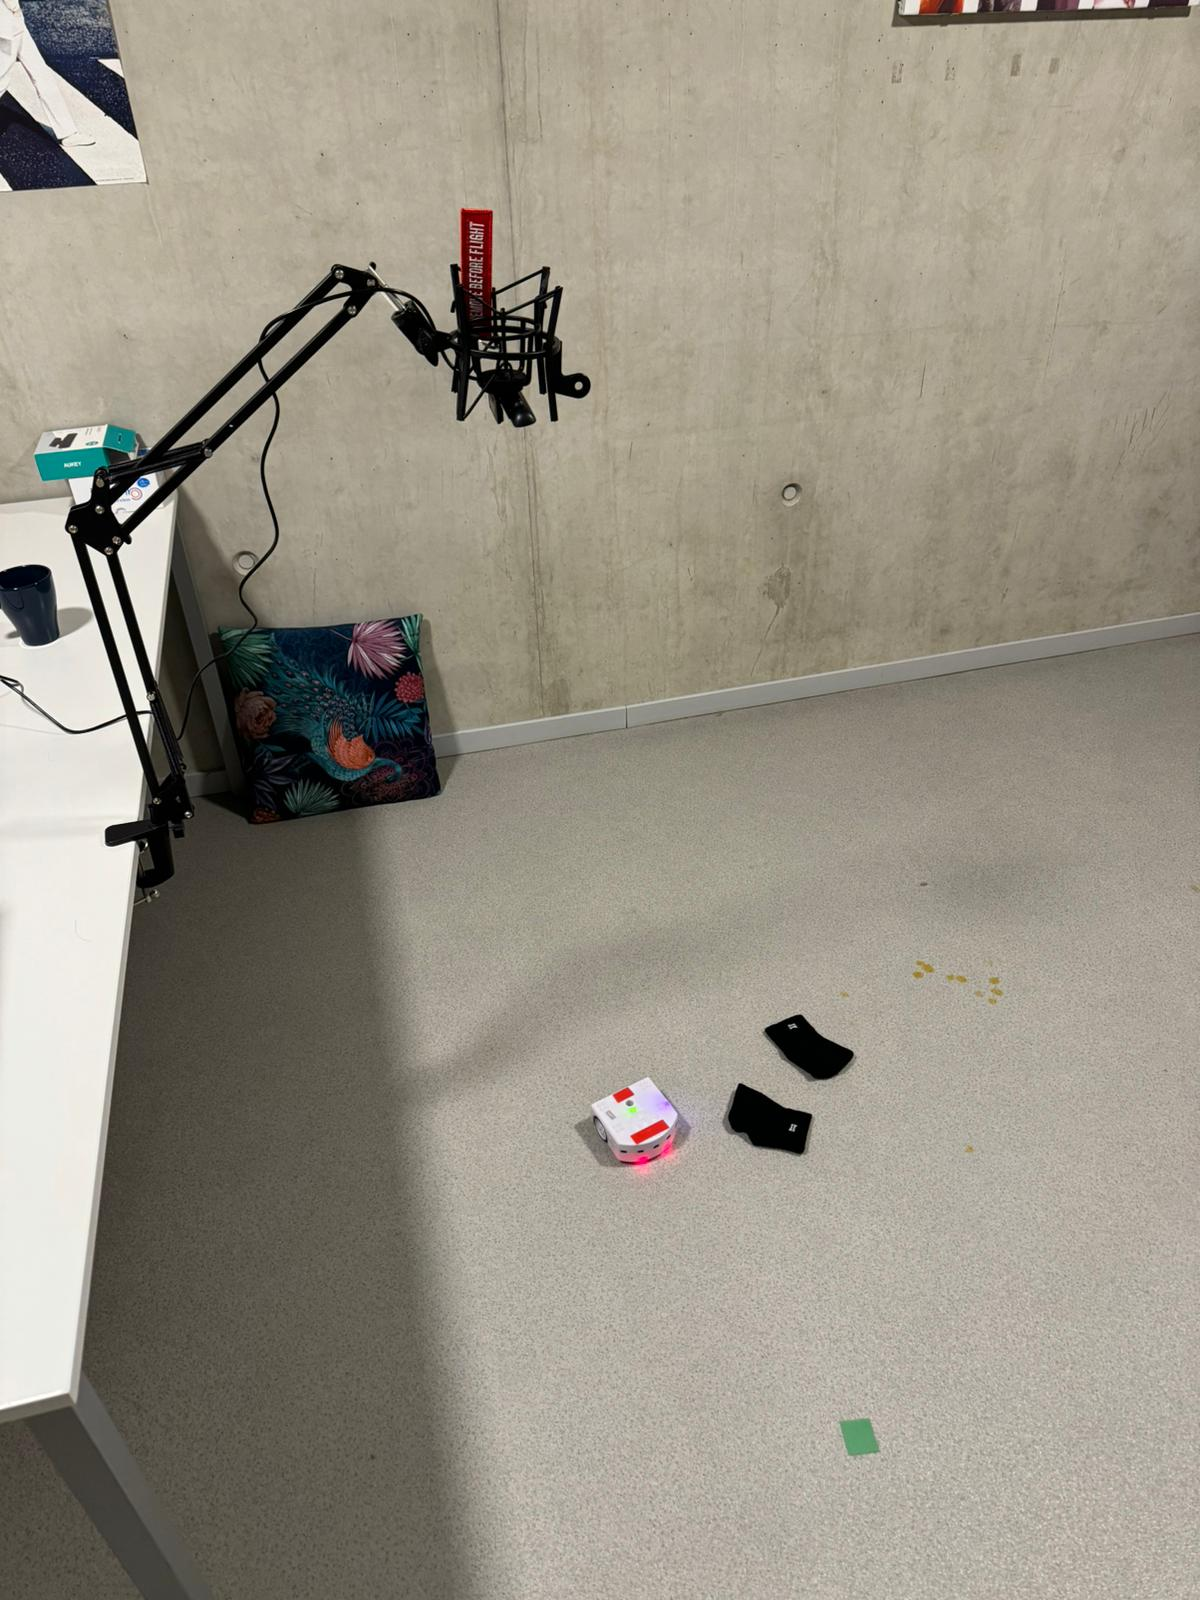


## 2. General program flow <a class="anchor" id="General_program_flow"></a>
### The overall program sequence is as follows:

The robot has 4 different states, which are the body of the program.

In each of these states, an image is periodically acquired.

When the program starts, the robot is in state 0. 
- State 0
    - The program searches for the robot until a path from the robot's position to the target can be calculated and stored in memory. Once this has been done, the robot switches to state 1.
- State 1
    - The robot follows the previously calculated path. It regularly corrects its trajectory using the Kalmann filter.
    - If the robot is kidnapped, it enters state 3.
    - If the robot detects an unexpected obstacle, it enters state 4.
    - If the robot has reached its goal, it stops.
- State 3:
    - the robot stops moving, and waits to be put back on the ground. When this is done, it returns to state 0.
- State 4:
    - the robot moves backwards until it can no longer see an obstacle, then returns to state 0.
 
### Use of asynchronous programming
Asynchronous programming was used to send command signals to the motor, to read values from the robot's proximity sensors and to read values from the motor speeds.

A simple diagram of the finite state machine is given below.

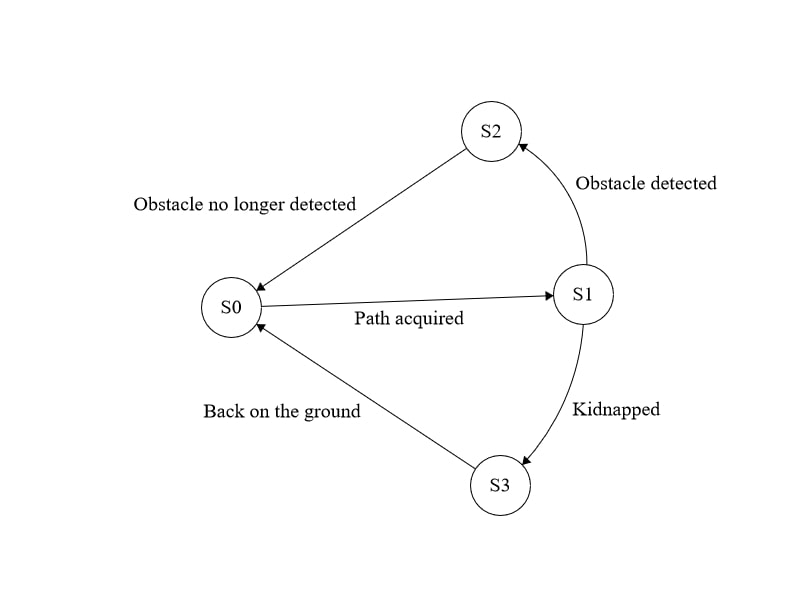

In [38]:
from IPython.display import HTML, Image
Image(filename='images/FSM.jpg', width=400, height=500) 



The following cell contains a video illustrating a simple case of the general program flow. In the video, the robot is never kidnapped, and no unplanned obstacle is being placed on its path, therefore, local navigation is never used here.

In [39]:
HTML(f"""
<video width="640" height="480" controls>
  <source src="videos/normal_behavior.mp4" type="video/mp4">
  Error, can't play video
</video>
""")

# 3. Computer vision <a class="anchor" id="Computer_vision"></a>

In [17]:
from vision.ComputerVision import Vision
# section to load all libraries required above explanations 

The vision aspect of our project is designed to navigate the robot through an environment with obstacles utlising a stationary camera. Our approach follows the following steps:

1. Detecting and locating the robot and its orientation 
2. Identifying obstacles and their boundaries 
3. Determining a goal position 
4. Computing the shortest path for the robot to reach the goal while avoiding obstacles. 

### Libraries used to aid Vision 
- `OpenCV`: Used for image detection, contour detection, geometric transformations, utilised to process captured frames and purpose the visual input to achieve the goal 
- `NumPy`: Utilised for all numerical operations
- `Pyvisgraph`: Utilised for computing optimal robot paths based on all calculations 
- `Shapely`: Utilised for manipulating planar geometric objects (to create union between obstacles that are close together)

### 3.1. Robot Detection and Localisation 

This is conducted throught the `find_robot()` function which operates solely on the defined vision class (as such this is the sole input). It accomplishes this through advanced image processing techniques, focusing on color filtering and contour detection, followed by a detailed analysis of the detected shapes.

Firstly, through *colour filitering* the image is converted from its original BGR format to RGB. We then apply a colour filter to isolate the colour red, which is present on the thymio robot (as per our assumptions). This is achieved through definind a specific range in the RBG colour space that corresponds ot the red colour, resulting in a binary mask whre the red areas are highlighted. 

Then we undergo *contour detection* by using `cv2.findContours()` to detect the exact shape and structure of the labelling on the thymio. These contours, representing the boundaries of the red shapes are critical for the accurate determination of the robot's position. A specific range of contour areas are checked, to denoise the result and only get the two markers contours and positions. The contour area feature is also used to differentiate between the nose marker and the tail marker on the robot.

This structure allows us to *calculate the centroids* by utilising the moments of the two contours. `cv2.moments()` allows for extraction of specific spatial moments required to compute the coordinates of the centroid which are calculated using the following formulae:

$$C_x = \frac{M_{10}}{M_{00}},\; C_y = \frac{M_{01}}{M_{00}}$$ 

The calculation of this centroid helps provide 5 critical pieces of information:
1. **Central reference point**: Concise and accurate position of robot in environment, calculated from the average of the two markers position.
2. **Orientation of robot**: The direction in which the robot is facing is inferred from the arctangent of the two centroids locations. 
3. **Scale Calibration**: By knowing the physical distance between the two marker centroids on the robot and comparing it with the pixel distance between their centroids in the image, you can establish a scale factor, providing the scale for all future calculations.
4. **Movement Analysis**: The centroid can be tracked in sequential frames, thus, changes in the centroid's location over time provide information about the speed and direction of the robot's movement. 
5. **Path Planning Input**: The positional data derived from the centroids assist significantly in the path planning process, to be elaborated later in the report. 



In [31]:
## Insert Image of robot being detected alongside supporting evidence for the above- such as orientation and Movement


### 3.2. Obstacle Detection
This is achieved through the `find_graph()` function which again takes in the vision class as its sole input. Obstacle detection is achieved through Greyscale conversion, thresholding, contour approximation which blends together to contribute to larger objective of creating a map for the robot to follow. 

The first step is *Greyscale Conversion* which significantly simplifies the process of identifying obstacles through `cv2.cvtColor()`. In greyscale, the intensity of each pixel represents different shades of grey, disregarding colour which is not needed to identify black (all obstacles are black as stated in assumptions). Once the image is rendered, *Thresholding* takes place which outputs an image where the black obstacles are distinctly visible against the background. 

In a similar process to above, the contours are detected but for obstacles, they are further simplifed in the process of *Contour Approximation* utilising `cv2.approxPolyDP()` to create the shape of the obstacles. This returns the object (obstacle) defined as a set of corners. This is done in order to balance between retaining the essential shape while reducing computational complexity. This serves to keep the algorithm efficient while maintaining accuracy. 

Finally, the boundaries of the actual obstacles and the robot have been defined. But in order to ensure that the path planning function is able to create a safe path through the obstacles, we conduct a *Vector Calculation* for Obstacles. 
This is done in `find_farthest_vector()` which takes in the set of corners for each of the obstacles, with the end goal being to create a safety net around obstacles to avoid collision. For each corner, this function calculates the sum of two vectors made from a first vector [previous_corner, corner] and [next_corner, coner] and normalizes it. We then get the vector pointing outward relative to an obstacle for each corner of an obstacle.

Then we can set the corners of each obstacles at a certain distance (determined using the scale factor obtained from the `find_robot()` function) along this vector from the obstacle. This helps create a buffer around the obstacles hence preventing the robot's path from getting too close to an obstacle. This also allows for the accomodation of any errors in measurement or movement. 

In [ ]:
IMAGE of both find graph output and find farthest vector output

### 3.3. Goal Identification
The function `find_goal()` is utilised to identify the green marker which is placed at the end objective (as per assumptions). This function operates in the vision class and returns the centroid position of the goal. As part of the Vision class, this method ensures that the goal's location is consistently updated and integrated with the robot's navigation system.

Similar to the Robot localisation, this function operates by first applying colour filtering to isolate green (as per assumptions about the goal colour). This mask is then applied to the image and contours are attached to accurately grasp the goal. Following the same process as the Robot Localisation above, centroids are calculated and the end goal of the robot is saved into the vision class, making it accessible for future calculations.  

In [ ]:
IMAGE FOR GREEN mask

### 3.4. Path Planning
The first step is to construct a visibility graph utilising `pyvisgraph` and general graph theory to visualise the corners of obstacles, robot's current position, and the goal. This is built in `find_graph` which goes through *Greyscale and Thresholding*, *Contour Detection and Polygon Approximation* and then *Vector Calculation for Safety Margins*. 

Once this processing is done, the space between obstacles is checked to ensure enough space for a thymio to travel through. For that, an algorithm checks if each polygon formed from the nodes around an obstacle intersect with other polygons. If two polygons are intersecting, they are combined into a bigger polygon, which the thymio will go around. This is done with the help of functions from the `shapely` library.

Finally, the visibility graph is built with the help of the `pyvisgraph` library, by feeding it a list of non-intersecting polygons coordinates. This will determine which all the neighbours of each node and store them in an object.

The `find_shortest_path()` function in the Vision class plays a pivotal role in the robot's navigation system. Taking in the above map where there are the integrated outputs from the robot detection, obstacle detection, and goal identification processes to compute the optimal path for the robot to reach its goal using Djikstra's algorithm. 

In [ ]:
INSERT Visuals

# 4. Filtering <a class="anchor" id="Filtering"></a> 

The implementation of a Kalman filter is necessary to obtain smooth performance. It allows our robot to obtain a more precise estimate of its position. Furthermore, if at some point the vision loses the robot (or the robot is hidden), the position estimate will still get updated thanks to the motion model. However, our uncertainty on position will increase until a new camera measurement is given.

### The state space model

A state space representation of our model can be given as follows:
\begin{equation}
        x_t = \begin{bmatrix}
        1&0&0\\
        0&1&0\\
        0&0&1\\
        \end{bmatrix} x_{t-1} + \begin{bmatrix}
                                \frac{R}{2}cos(x_{3,t-1})\Delta t & \frac{R}{2}cos(x_{3,t-1})\Delta t\\
                                \frac{R}{2}sin(x_{3,t-1})\Delta t & \frac{R}{2}sin(x_{3,t-1})\Delta t\\
                                -\frac{R}{d}\Delta t & \frac{R}{d}\Delta t\\
                                \end{bmatrix} u
\end{equation}

\begin{equation}
        y_t = \begin{bmatrix}
        1&0&0\\
        0&1&0\\
        0&0&1\\
        \end{bmatrix} x_t
\end{equation}

with R the radius of the wheels, d the wheelbase of the thymio and:

\begin{equation}
        x_t = \begin{bmatrix}
                x_{1,t}\\
                x_{2,t}\\
                x_{3,t}\\
                \end{bmatrix} = \begin{bmatrix}
                                x_t\\
                                y_t\\
                                \theta_t\\
                                \end{bmatrix} \text{and } u = \begin{bmatrix}
                                                                \omega_r\\
                                                                \omega_l\\
                                                                \end{bmatrix}
        \end{equation}

### Filter choice and parameters
We can see in the model above that our model has no non-linearities ($x_{3,t-1}$ is already known at time $t$ so $cos(x_{3,t-1})$ and $sin(x_{3,t-1})$ are scalars). We can therefore use a linear Kalman filter.

In [ ]:



dt calculated using average by running main

changer le - dans z quand ce ser aregler dans vision

# 5. General motion

When the program has been able to calculate the path the robot must take, it has a list of coordinates in memory, which are the positions the robot must pass through to reach the goal.

Here we describe how the robot follows the trajectory from one point to another, without kidnapping and without unexpected obstacles in its path.

Each time the robot passes through the loop, after the vision has been updated (and the robot's position and angle measured), the Kalmann filter is used to update the robot's position estimate.

We then check whether the robot's estimated position is approximately equal to its current target (the current node in the list containing the planned path), using the `close_coordinates(x, y, w, z)` function. This function compares two positions and returns True if they are approximately equal. If this is the case, the robot changes its objective, which becomes the next node in the list of nodes to visit.

Next, the program checks whether the robot's estimated angle is approximately equal to the angle between its current position and its target (computed using the function `compute_movement(current_pos, obj)` ). If the difference is too great, the robot rotates until it is aligned. It then runs in a straight line.
The code below is the implementation of what is described above.

In [ ]:
while state == 1: # Drive towards goal state
        print(state)
        while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
            continue
        vis.show()
        vis.update()
        
        await client.sleep(0.01)
        await node.wait_for_variables()

    
    ##REST OF STATE 1

    
         # Setting up and running the Kalman Filter
        speed_left = node.v.motor.left.speed
        speed_right = node.v.motor.right.speed
        prev_angle = rob_pos[2]
        #rob_pos = filtering.run_filter(speed_right, speed_left, prev_angle, vis,R,d,time.time()-last_image_time)
        rob_pos = [vis.robot.x, vis.robot.y, -vis.robot.angle]
        # Checking if we arrived at the next node
        arrived_node = motion_functions.close_coordinates(rob_pos[0], rob_pos[1], path[target_node][0], path[target_node][1])
        print("target node",target_node)
        if (arrived_node):
            if (target_node) < len(path)-1:
                target_node += 1
            else:
                print("ARRIVED")
                await motion_functions.stop(node)
                goal_reached = True
                break # Exiting the first while loop
        
        # Rotating and driving towards the next node
        if rotation_done:
            angle = motion_functions.compute_movement([rob_pos[0], rob_pos[1]], [path[target_node][0], path[target_node][1]], rob_pos[2])
            if abs(angle - rob_pos[2]) > 0.2:
                rotation_done = 0
                await motion_functions.rotate(angle-rob_pos[2], node)
            
        if  angle + 0.2 > rob_pos[2] and angle - 0.2 < rob_pos[2]:
            rotation_done = 1
            await motion_functions.drive(node)
            
    ## REST OF STATE 1

# 6. Local avoidance <a class="anchor" id="Local_avoidance"></a>

### Requirements on the obstacles for local avoidance
For local avoidance to work, obstacles must have the following characteristics: 
- The obstacles must be black:
  - because path planning can only be carried out with black obstacles. If the obstacle placed is not black, the robot will detect it and move backwards, but when it recalculates its path, it will not take the new obstacle into account.
- Measure more than 5 cm in height:
   - otherwise the obstacle cannot be detected by the proximity sensors.

### Local avoidance implementation
Local avoidance is implemented as follows: 
If, during the program run, while the robot is moving towards its goal (in state 1), the value read by one of the horizontal proximity sensors is greater than a defined constant (THRESHOLD_OBSTACLE), a boolean variable obstacle_detected is set to True. The constant threshold obstacle has been set to 100 empirically. The function that updates this boolean is `get_sensors(node)`. When an obstacle is detected, the robot changes state to state 4.  
The following cell contains the function get_sensors(node). This function is the same function that is used to identify whether or not the robot has been kidnapped.


In [ ]:
def get_sensors(node):
    prox_values = node["prox.horizontal"][:5]

    obstacle_detected = any(value > SEUIL_OBSTACLE for value in prox_values)
    
    ground_values = node["prox.ground.reflected"]
    
    if ground_values[0] < SEUIL_KIDNAPPED or ground_values[1] < SEUIL_KIDNAPPED:
        kidnapped = True 
    else:
        kidnapped = False
    return kidnapped, obstacle_detected

The following cell contains the portion of the code that changes the state to state 4

In [ ]:
while state == 1: # Drive towards goal state
        print(state)
        while time.time()-last_image_time < dt: # Acquire a new image every dt seconds
            continue
        vis.show()
        vis.update()
        
        await client.sleep(0.01)
        await node.wait_for_variables()
        
        # Get proximity sensors' values
        kidnapped, obstacle_detected = motion_functions.get_sensors(node)
        # Checking for unforseen obstacle
        if obstacle_detected:
            await motion_functions.stop(node)
            state = 4
            break

As long as the robot is in state 4, the robot moves backwards in a straight line, until the proximity sensors no longer detect an obstacle.
When the robot has moved back far enough, to the point where it no longer detects an obstacle, it changes state and returns to state 0. In this way, it recalculates its new path, taking into account the newly added obstacle. The program then returns to its general behavior.
The following cell contains the state 4 of the robot :

In [ ]:
while state == 4: # Local avoidance state
        vis.shortest_path = [] # Deleting the previous path to make sure a new one is computed
        
        while obstacle_detected:
            while time.time()-last_image_time < dt: # Acquire a new image every dt seconds
                continue
            vis.show()
            vis.update()
            
            await client.sleep(0.01)
            await node.wait_for_variables()
            kidnapped, obstacle_detected = motion_functions.get_sensors(node)
            await motion_functions.drive_back(node)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        await motion_functions.stop(node)
        state = 0

The cell below contains a video that illustrates local avoidance

In [16]:

HTML(f"""
<video width="640" height="480" controls>
  <source src="videos/local_avoidance.mp4" type="video/mp4">
  Error, can't play video
</video>
""")

# 7. Kidnapping <a class="anchor" id="Kidnapping"></a>

Kidnapping is detected in a similar way to local avoidance. When the program is in state 1 (i.e. the robot is heading towards its goal), if the robot is abducted, the two sensors facing the ground determine whether the robot has been kidnapped. The function that handles this is `get_sensors(node)`. The sensors will return a small value, close to zero. If the value returned by the sensors is smaller than a defined threshold (SEUIL_KIDNAPPED), then the kidnapped Boolean variable is set to TRUE. In the state 1, if kidnapped is True, the motors stop turning, and the state is changed to state 3. The cell below shows the portion of code in state 1 changing the state to state 3 if the robot has been kidnapped.

In [ ]:
while state == 1: # Drive towards goal state
        print(state)
        while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
            continue
        vis.show()
        vis.update()

#PORTION OF CODE...

# Checking for kidnapping
        if kidnapped:
            state = 3 # Kidnapped state
            vis.shortest_path = [] # Deleting the previous path to make sure a new one is computed
            await motion_functions.stop(node)
            break
            
#REST OF STATE 1

While the robot is in state 3, the motors do not move and the values of its ground proximity sensors are read periodically using the function `get_sensors(node)`, so that if the sensors detect the ground again, the robot is returned to state 0. It will then recalculate its path and the program will resume normal operation.

In [ ]:
while state == 3: # State in case of kidnapping
        while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
            continue
        vis.show()
        vis.update()
        
        await client.sleep(0.01)
        await node.wait_for_variables()
        kidnapped, obstacle_detected = motion_functions.get_sensors(node)
        
        if not kidnapped:
            state = 0
            rotation_done = 1
        
        last_image_time = time.time()
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

The following cell contains a video that illustrates kidnapping behavior

In [41]:
HTML(f"""
<video width="640" height="480" controls>
  <source src="videos/kidnapping.mp4" type="video/mp4">
  Error, can't play video
</video>
""")

# 8. Conclusion <a class="anchor" id="Conclusion"></a>